In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

# Functions For Reading Tint Data

In [2]:
import struct
import numpy.matlib
def getspikes(fullpath):
    """
    This function will return the spike data, spike times, and spike parameters from Tint tetrode data.

    Example:
        tetrode_fullpath = 'C:\\example\\tetrode_1.1'
        ts, ch1, ch2, ch3, ch4, spikeparam = getspikes(tetrode_fullpath)

    Args:
        fullpath (str): the fullpath to the Tint tetrode file you want to acquire the spike data from.

    Returns:
        ts (ndarray): an Nx1 array for the spike times, where N is the number of spikes.
        ch1 (ndarray) an NxM matrix containing the spike data for channel 1, N is the number of spikes,
            and M is the chunk length.
        ch2 (ndarray) an NxM matrix containing the spike data for channel 2, N is the number of spikes,
            and M is the chunk length.
        ch3 (ndarray) an NxM matrix containing the spike data for channel 3, N is the number of spikes,
            and M is the chunk length.
        ch4 (ndarray) an NxM matrix containing the spike data for channel 4, N is the number of spikes,
            and M is the chunk length.
        spikeparam (dict): a dictionary containing the header values from the tetrode file.
        
        - Geoff Barrett
    """
    spikes, spikeparam = importspikes(fullpath)
    ts = spikes['t']
    nspk = spikeparam['num_spikes']
    spikelen = spikeparam['samples_per_spike']

    ch1 = spikes['ch1']
    ch2 = spikes['ch2']
    ch3 = spikes['ch3']
    ch4 = spikes['ch4']

    return ts, ch1, ch2, ch3, ch4, spikeparam


def importspikes(filename):
    """Reads through the tetrode file as an input and returns two things, a dictionary containing the following:
    timestamps, ch1-ch4 waveforms, and it also returns a dictionary containing the spike parameters
    
    - Geoff Barrett
    """

    with open(filename, 'rb') as f:
        for line in f:
            if 'data_start' in str(line):
                spike_data = np.fromstring((line + f.read())[len('data_start'):-len('\r\ndata_end\r\n')], dtype='uint8')
                break
            elif 'num_spikes' in str(line):
                num_spikes = int(line.decode(encoding='UTF-8').split(" ")[1])
            elif 'bytes_per_timestamp' in str(line):
                bytes_per_timestamp = int(line.decode(encoding='UTF-8').split(" ")[1])
            elif 'samples_per_spike' in str(line):
                samples_per_spike = int(line.decode(encoding='UTF-8').split(" ")[1])
            elif 'bytes_per_sample' in str(line):
                bytes_per_sample = int(line.decode(encoding='UTF-8').split(" ")[1])
            elif 'timebase' in str(line):
                timebase = int(line.decode(encoding='UTF-8').split(" ")[1])
            elif 'duration' in str(line):
                duration = int(line.decode(encoding='UTF-8').split(" ")[1])
            elif 'sample_rate' in str(line):
                samp_rate = int(line.decode(encoding='UTF-8').split(" ")[1])

                # calculating the big-endian and little endian matrices so we can convert from bytes -> decimal
    big_endian_vector = 256 ** np.arange(bytes_per_timestamp - 1, -1, -1)
    little_endian_matrix = np.arange(0, bytes_per_sample).reshape(bytes_per_sample, 1)
    little_endian_matrix = 256 ** numpy.matlib.repmat(little_endian_matrix, 1, samples_per_spike)

    number_channels = 4

    # calculating the timestamps
    t_start_indices = np.linspace(0, num_spikes * (bytes_per_sample * samples_per_spike * 4 +
                                                   bytes_per_timestamp * 4), num=num_spikes, endpoint=False).astype(
        int).reshape(num_spikes, 1)
    t_indices = t_start_indices

    for chan in np.arange(1, number_channels):
        t_indices = np.hstack((t_indices, t_start_indices + chan))

    t = spike_data[t_indices].reshape(num_spikes, bytes_per_timestamp)  # acquiring the time bytes
    t = np.sum(np.multiply(t, big_endian_vector), axis=1) / timebase  # converting from bytes to float values
    t_indices = None

    waveform_data = np.zeros((number_channels, num_spikes, samples_per_spike))  # (dimensions, rows, columns)

    bytes_offset = 0
    # read the t,ch1,t,ch2,t,ch3,t,ch4

    for chan in range(number_channels):  # only really care about the first time that gets written
        chan_start_indices = t_start_indices + chan * samples_per_spike + bytes_per_timestamp + bytes_per_timestamp * chan
        for spike_sample in np.arange(1, samples_per_spike):
            chan_start_indices = np.hstack((chan_start_indices, t_start_indices +
                                            chan * samples_per_spike + bytes_per_timestamp +
                                            bytes_per_timestamp * chan + spike_sample))
        waveform_data[chan][:][:] = spike_data[chan_start_indices].reshape(num_spikes, samples_per_spike).astype(
            'int8')  # acquiring the channel bytes
        waveform_data[chan][:][:][np.where(waveform_data[chan][:][:] > 127)] -= 256
        waveform_data[chan][:][:] = np.multiply(waveform_data[chan][:][:], little_endian_matrix)

    spikeparam = {'timebase': timebase, 'bytes_per_sample': bytes_per_sample, 'samples_per_spike': samples_per_spike,
                  'bytes_per_timestamp': bytes_per_timestamp, 'duration': duration, 'num_spikes': num_spikes,
                  'sample_rate': samp_rate}

    return {'t': t.reshape(num_spikes, 1), 'ch1': np.asarray(waveform_data[0][:][:]),
            'ch2': np.asarray(waveform_data[1][:][:]),
            'ch3': np.asarray(waveform_data[2][:][:]), 'ch4': np.asarray(waveform_data[3][:][:])}, spikeparam


def get_setfile_parameter(parameter, set_filename):
    """
    This function will return the parameter value of a given parameter name for a given set filename.

    Example:
        set_fullpath = 'C:\\example\\tetrode_1.1'
        parameter_name = 'duration
        duration = get_setfile_parameter(parameter_name, set_fullpath)

    Args:
        parameter (str): the name of the set file parameter that you want to obtain.
        set_filename (str): the full path of the .set file that you want to obtain the parameter value from.


    Returns:
        parameter_value (str): the value for the given parameter
        
    - Geoff Barrett

    """

    if not os.path.exists(set_filename):
        return

    # adding the encoding because tint data is created via windows and if you want to run this in linux, you need
    # to explicitly say this
    with open(set_filename, 'r+', encoding='cp1252') as f:
        for line in f:
            if parameter in line:
                if line.split(' ')[0] == parameter:
                    # prevents part of the parameter being in another parameter name
                    new_line = line.strip().split(' ')
                    if len(new_line) == 2:
                        return new_line[-1]
                    else:
                        return ' '.join(new_line[1:])
                    

# Pre-Processing (Whiten)

In [5]:
from mountainlab_pytools import mdaio
import numpy as np
import multiprocessing
import time
import os

class SharedChunkInfo():
    def __init__(self,num_chunks):
        self.timer_timestamp = multiprocessing.Value('d',time.time(),lock=False)
        self.last_appended_chunk = multiprocessing.Value('l',-1,lock=False)
        self.num_chunks=num_chunks
        self.num_completed_chunks = multiprocessing.Value('l',0,lock=False)
        self.lock = multiprocessing.Lock()
    def reportChunkCompleted(self,num):
        with self.lock:
            self.num_completed_chunks.value+=1
    def reportChunkAppended(self,num):
        with self.lock:
            self.last_appended_chunk.value=num
    def lastAppendedChunk(self):
        with self.lock:
            return self.last_appended_chunk.value
    def resetTimer(self):
        with self.lock:
            self.timer_timestamp.value=time.time()
    def elapsedTime(self):
        with self.lock:
            return time.time()-self.timer_timestamp.value
    def printStatus(self):
        with self.lock:
            print('Processed {} of {} chunks...'.format(self.num_completed_chunks.value,self.num_chunks))

def compute_AAt_matrix_for_chunk(num):
    opts=g_opts
    in_fname=opts['timeseries'] # The entire (large) input file
    out_fname=opts['timeseries_out'] # The entire (large) output file
    chunk_size=opts['chunk_size']
    
    X=mdaio.DiskReadMda(in_fname)
    
    t1=int(num*opts['chunk_size']) # first timepoint of the chunk
    t2=int(np.minimum(X.N2(),(t1+chunk_size))) # last timepoint of chunk (+1)
    
    # Ensuring that this chunk value is float64 to avoid svd complications
    # we have to make sure to remove the first row which are time values
    chunk=X.readChunk(i1=0,N1=X.N1(),i2=t1,N2=t2-t1)[1:,:].astype(np.float32) # Read the chunk
    
    ret=chunk @ np.transpose(chunk)
    
    return ret

def whiten_chunk(num,W):
    #print('Whitening {}'.format(num))
    opts=g_opts
    #print('Whitening chunk {} of {}'.format(num,opts['num_chunks']))
    in_fname=opts['timeseries'] # The entire (large) input file
    out_fname=opts['timeseries_out'] # The entire (large) output file
    chunk_size=opts['chunk_size']
    
    X=mdaio.DiskReadMda(in_fname)
    
    t1=int(num*opts['chunk_size']) # first timepoint of the chunk
    t2=int(np.minimum(X.N2(),(t1+chunk_size))) # last timepoint of chunk (+1)
    
    chunk=X.readChunk(i1=0,N1=X.N1(),i2=t1,N2=t2-t1) # Read the chunk
    
    # ensuring that the time points aren't whitened
    chunk[1:,:] = W @ chunk[1:,:]
    
    ###########################################################################################
    # Now we wait until we are ready to append to the output file
    # Note that we need to append in order, thus the shared_data object
    ###########################################################################################
    g_shared_data.reportChunkCompleted(num) # Report that we have completed this chunk
    while True:
        if num == g_shared_data.lastAppendedChunk()+1:
            break
        time.sleep(0.005) # so we don't saturate the CPU unnecessarily
    
    # Append the filtered chunk (excluding the padding) to the output file
    mdaio.appendmda(chunk,out_fname)
    
    # Report that we have appended so the next chunk can proceed
    g_shared_data.reportChunkAppended(num)

    # Print status if it has been long enough
    if g_shared_data.elapsedTime()>4:
        g_shared_data.printStatus()
        g_shared_data.resetTimer()

def whiten(*, timeseries,timeseries_out,
        clip_size=50, num_clips_per_chunk=6000, num_processes=os.cpu_count()
        ):
    """
    Whiten a multi-channel timeseries
    Parameters
    ----------
    timeseries : INPUT
        MxN raw timeseries array (M = #channels, N = #timepoints)
        
    timeseries_out : OUTPUT
        Whitened output (MxN array)
    """
    
    chunk_size = int(clip_size * num_clips_per_chunk)
    
    X=mdaio.DiskReadMda(timeseries)
    M=X.N1() # Number of channels (+1 since time is the 1st row)
    N=X.N2() # Number of timepoints

    # chunk_size=N # right now we are putting all the data into one chunk
    
    num_chunks_for_computing_cov_matrix=10
    
    num_chunks=int(np.ceil(N/chunk_size))
    print ('Chunk size: {}, Num chunks: {}, Num processes: {}'.format(chunk_size,num_chunks,num_processes))
    
    opts={
        "timeseries":timeseries,
        "timeseries_out":timeseries_out,
        "chunk_size":chunk_size,
        "num_processes":num_processes,
        "num_chunks":num_chunks
    }
    global g_opts
    g_opts=opts
    
    pool = multiprocessing.Pool(processes=num_processes)
    step=int(np.maximum(1,np.floor(num_chunks/num_chunks_for_computing_cov_matrix)))
    AAt_matrices=pool.map(compute_AAt_matrix_for_chunk,range(0,num_chunks,step),chunksize=1)
    
    AAt=np.zeros((M-1,M-1),dtype='float64')
    
    for M0 in AAt_matrices:
        ##important: need to fix the denominator here to account for possible smaller chunk
        AAt+=M0/(len(AAt_matrices)*chunk_size) 
    
    U, S, Ut = np.linalg.svd(AAt, full_matrices=True)
    
    W = (U @ np.diag(1/np.sqrt(S))) @ Ut
    #print ('Whitening matrix:')
    #print (W)
    
    global g_shared_data
    g_shared_data=SharedChunkInfo(num_chunks)
    mdaio.writemda32(np.zeros([M,0]),timeseries_out)
    
    pool = multiprocessing.Pool(processes=num_processes)
    pool.starmap(whiten_chunk,[(num,W) for num in range(0,num_chunks)],chunksize=1)
    
    return True

# Mountain Sort 4 - Snippets Edition 

In [6]:
import numpy as np
import isosplit5
from mountainlab_pytools import mdaio
import sys
import os
import multiprocessing

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
import h5py

warnings.resetwarnings()


def get_channel_neighborhood(m, Geom, *, adjacency_radius):
    M = Geom.shape[0]
    if adjacency_radius < 0:
        return np.arange(M)
    deltas = Geom - np.tile(Geom[m, :], (M, 1))
    distsqrs = np.sum(deltas ** 2, axis=1)
    inds = np.where(distsqrs <= adjacency_radius ** 2)[0]
    inds = np.sort(inds)
    return inds.ravel()


def subsample_array(X, max_num):
    if X.size == 0:
        return X
    if max_num >= len(X):
        return X
    inds = np.random.choice(len(X), max_num, replace=False)
    return X[inds]


def compute_principal_components(X, num_components):
    u, s, vt = np.linalg.svd(X)
    u = u[:, :num_components]
    return u


def compute_template_channel_peaks(templates, *, detect_sign):
    if detect_sign < 0:
        templates = templates * (-1)
    elif detect_sign == 0:
        templates = np.abs(templates)
    else:
        pass
    tc_peaks = np.max(templates, axis=1)
    tc_peak_times = np.argmax(templates, axis=1)
    return tc_peaks, tc_peak_times


def compute_sliding_maximum_snippet(snippets, radius=10):
    """This will be a sliding maximum. 

    It will return a nSpikes x clip_size matrix (ret), for each
    sample it will look at samples half of the radius before and half after
    and to determine the local max for each sample.

    snippets: nSpikes x clip_size matrix"""
    ret = np.zeros_like(snippets)
    max_i = snippets.shape[-1]
    half_radius = int(radius / 2)
    for i in np.arange(snippets.shape[-1]):
        start = i - half_radius
        stop = i + half_radius
        if start < 0: start = 0
        if stop > max_i: stop = max_i
        ret[:, i] = np.amax(snippets[:, start:stop], axis=1)

    return ret.flatten()


def remove_zero_features(X):
    maxvals = np.max(np.abs(X), axis=1)
    features_to_use = np.where(maxvals > 0)[0]
    return X[features_to_use, :]


def cluster(features, *, npca):
    num_events_for_pca = np.minimum(features.shape[1], 1000)
    subsample_inds = np.random.choice(features.shape[1], num_events_for_pca, replace=False)
    u, s, vt = np.linalg.svd(features[:, subsample_inds])
    features2 = (u.transpose())[0:npca, :] @ features
    features2 = remove_zero_features(features2)
    labels = isosplit5.isosplit5(features2)
    return labels


def branch_cluster(features, *, branch_depth=2, npca=10):
    if features.size == 0:
        return np.array([])

    min_size_to_try_split = 20
    labels1 = cluster(features, npca=npca).ravel().astype('int64')
    if np.min(labels1) < 0:
        tmp_fname = '/tmp/isosplit5-debug-features.mda'
        mdaio.writemda32(features, tmp_fname)
        raise Exception('Unexpected error in isosplit5. Features written to {}'.format(tmp_fname))
    K = int(np.max(labels1))
    if K <= 1 or branch_depth <= 1:
        return labels1
    label_offset = 0
    labels_new = np.zeros(labels1.shape, dtype='int64')
    for k in range(1, K + 1):
        inds_k = np.where(labels1 == k)[0]
        if len(inds_k) > min_size_to_try_split:
            labels_k = branch_cluster(features[:, inds_k], branch_depth=branch_depth - 1, npca=npca)
            K_k = int(np.max(labels_k))
            labels_new[inds_k] = label_offset + labels_k
            label_offset += K_k
        else:
            labels_new[inds_k] = label_offset + 1
            label_offset += 1
    return labels_new


def write_firings_file(channels, times, labels, clip_inds, fname):
    L = len(channels)
    X = np.zeros((4, L), dtype='float64')
    X[0, :] = channels
    X[1, :] = times
    X[2, :] = labels
    X[3, :] = clip_inds
    mdaio.writemda64(X, fname)


def detect_on_neighborhood_from_snippets_model(X, channel_number, *, nbhd_channels, detect_threshold, detect_interval,
                                               detect_sign, clip_size, chunk_infos):
    """
        X - Snippet Model
        channel_number - The channel that you want to get the times from

    """
    t1 = chunk_infos[0]['t1']
    t2 = chunk_infos[0]['t2']

    # data_t = X.getChunk(t1=t1,t2=t2,channels=[0]).astype(np.int32)
    # we add 1 to the channel number since the first channel is the times
    # data = X.getChunk(t1=t1,t2=t2,channels=[channel_number+1]).astype(np.int32)
    data = X.getChunk(t1=t1, t2=t2, channels=nbhd_channels + 1).astype(np.int32)

    M = X.numChannels() - 1  # number of data channels
    channel_rel = np.where(nbhd_channels == channel_number)[0][
        0]  # The relative index of the central channel in the neighborhood

    if detect_sign < 0:
        # negative peaks
        data = np.multiply(data, -1)
    elif detect_sign == 0:
        # both negative and positive peaks
        data = np.abs(data)
    elif detect_sign > 0:
        # positive peaks
        pass
    
    # find the max values of the channel data (reshaped like nSpikes x clip_size)
    max_inds = np.argmax(data[channel_rel, :].reshape((-1, clip_size)), axis=1)
    clip_inds = np.arange(len(max_inds))  # also returning the clip indices

    # converting it so the indices matches the flattened data
    max_inds = np.arange(len(max_inds)) * clip_size + max_inds
    
    # find the max values to compare to threshold
    max_vals = data[channel_rel, :][max_inds]

    # return indices where the threshold has been reached
    threshold_bool = np.where(max_vals >= detect_threshold)[0]

    # the sample number that refers to the spike events on the chosen channel
    times = max_inds[threshold_bool]
    
    # the snippet index number corresponding to that event
    clip_inds = clip_inds[threshold_bool]

    # now we will calculate if the peak belongs to this channel's neighborhood
    data = data.reshape((M, -1, clip_size))

    # this will find the local neighborhood maximum for each point
    nearby_neighborhood_maximum0 = compute_sliding_maximum_snippet(np.amax(data, axis=0), radius=detect_interval)

    vals = data[channel_rel, :].flatten()[times]
    assign_to_this_neighborhood = (vals == nearby_neighborhood_maximum0[times])

    return times, clip_inds, assign_to_this_neighborhood


def compute_event_features_from_snippets(X, times, clip_ind, *, nbhd_channels, clip_size, max_num_clips_for_pca,
                                         num_features, chunk_infos):
    """compute_event_features_from_snippets
    X - the snippets model 
    times - sample value of the channel peaks (for the central channel chosen)
    clip_ind - the 
    """
    if times.size == 0:
        return np.array([])

        # N=X.numTimepoints()
    # X_neigh=X.getChunk(t1=0,t2=N,channels=nbhd_channels)
    M_neigh = len(nbhd_channels)

    # padding=clip_size*10

    # Subsample and extract clips for pca

    # times_for_pca=subsample_array(times,max_num_clips_for_pca)
    clips_inds_for_pca = subsample_array(clip_ind, max_num_clips_for_pca)

    t1 = chunk_infos[0]['t1']
    t2 = chunk_infos[0]['t2']

    # we add 1 to the channel number since the first channel is the times
    clips = X.getChunk(t1=t1, t2=t2, channels=nbhd_channels + 1).astype(np.int32)
    clips = clips.reshape((M_neigh, -1, clip_size))
    clips = np.swapaxes(clips, 1, 2)  # swapping axes
    clips_for_pca = clips[:, :, clips_inds_for_pca]

    # Compute the principal components
    # use twice as many features, because of branch method
    principal_components = compute_principal_components(
        clips_for_pca.reshape((M_neigh * clip_size, len(clips_inds_for_pca))),
        num_features * 2)  # (MT x 2F)

    # Compute the features for all the clips

    # projecting clip data onto the principal component axis
    features = principal_components.transpose() @ clips[:, :, clip_ind].reshape(
        (M_neigh * clip_size, len(times)))  # (2F x MT) @ (MT x L0) -> (2F x L0)

    return features


def get_real_times(X, times, *, time_channel, chunk_infos):
    """The times that we are dealing with are really just index values if we concatenated
    all the snippets to a nCh x clip_size*n_spikes matrix.

    We will bring back the time information as the 1st row of data in the .mda file represents
    the sample number that the chunk sample was recorded at (before it was removed from the continuos data).
    """

    t1 = chunk_infos[0]['t1']
    t2 = chunk_infos[0]['t2']

    # we add 1 to the channel number since the first channel is the times
    data_t = X.getChunk(t1=t1, t2=t2, channels=[time_channel]).astype(np.int32)
    
    return data_t[0, times]


def compute_templates_from_snippets_model(X, times, clip_ind, labels, *, nbhd_channels, clip_size, chunk_infos):
    # TODO: subsample smartly here

    M0 = len(nbhd_channels)

    t1 = chunk_infos[0]['t1']
    t2 = chunk_infos[0]['t2']

    # we add 1 to the channel number since the first channel is the times
    clips = X.getChunk(t1=t1, t2=t2, channels=nbhd_channels + 1).astype(np.int32)
    clips = clips.reshape((M0, -1, clip_size))
    clips = clips[:, clip_ind, :]
    clips = np.swapaxes(clips, 1, 2)  # swapping axes

    K = np.max(labels) if labels.size > 0 else 0
    template_sums = np.zeros((M0, clip_size, K), dtype='float64')
    template_counts = np.zeros(K, dtype='float64')

    for k in range(K):
        inds_k = np.where(labels == (k + 1))[0]
        if len(inds_k) > 0:
            template_counts[k] += len(inds_k)
            template_sums[:, :, k] += np.sum(clips[:, :, inds_k], axis=2).reshape((M0, clip_size))

    templates = np.zeros((M0, clip_size, K))
    for k in range(K):
        if template_counts[k]:
            templates[:, :, k] = template_sums[:, :, k] / template_counts[k]
    return templates


def create_chunk_infos(*, N):
    chunk_infos = []
    chunk_size = N  # I have changed it so all the data is on one chunk
    num_chunks = int(np.ceil(N / chunk_size))
    for i in range(num_chunks):
        chunk = {
            't1': i * chunk_size,
            't2': np.minimum(N, (i + 1) * chunk_size)
        }
        chunk_infos.append(chunk)
    return chunk_infos


class _NeighborhoodSorter:
    def __init__(self):
        self._sorting_opts = None
        self._clip_size = None
        self._snippets = None
        self._geom = None
        self._central_channel = None
        self._hdf5_path = None
        self._num_assigned_event_time_arrays = 0
        self._num_assigned_event_clip_ind_arrays = 0

    def setSortingOpts(self, opts):
        self._sorting_opts = opts

    def setSnippetsModel(self, model):
        self._snippets = model

    def setHdf5FilePath(self, path):
        self._hdf5_path = path

    def setGeom(self, geom):
        self._geom = geom

    def setCentralChannel(self, m):
        self._central_channel = m

    def getPhase1ClipInds(self):
        with h5py.File(self._hdf5_path, "r") as f:
            return np.array(f.get('phase1-clip_inds'))

    def getPhase1Times(self):
        with h5py.File(self._hdf5_path, "r") as f:
            return np.array(f.get('phase1-times'))

    def getPhase1ChannelAssignments(self):
        with h5py.File(self._hdf5_path, "r") as f:
            return np.array(f.get('phase1-channel-assignments'))

    def getPhase2ClipInds(self):
        with h5py.File(self._hdf5_path, "r") as f:
            return np.array(f.get('phase2-clip_inds'))

    def getPhase2Times(self):
        with h5py.File(self._hdf5_path, "r") as f:
            return np.array(f.get('phase2-times'))

    def getPhase2Labels(self):
        with h5py.File(self._hdf5_path, "r") as f:
            return np.array(f.get('phase2-labels'))

    def addAssignedEventTimes(self, times):
        with h5py.File(self._hdf5_path, "a") as f:
            f.create_dataset('assigned-event-times-{}'.format(self._num_assigned_event_time_arrays), data=times)
            self._num_assigned_event_time_arrays += 1

    def addAssignedEventClipIndices(self, clip_inds):
        with h5py.File(self._hdf5_path, "a") as f:
            f.create_dataset('assigned-event-clip_inds-{}'.format(self._num_assigned_event_clip_ind_arrays),
                             data=clip_inds)
            self._num_assigned_event_clip_ind_arrays += 1

    def runPhase1Sort(self):
        self.runSort(mode='phase1')

    def runPhase2Sort(self):
        self.runSort(mode='phase2')

    def runSort(self, *, mode):
        X = self._snippets
        M_global = X.numChannels() - 1
        N = X.numTimepoints()

        o = self._sorting_opts
        m_central = self._central_channel
        clip_size = o['clip_size']
        detect_interval = o['detect_interval']
        detect_sign = o['detect_sign']
        detect_threshold = o['detect_threshold']
        num_features = o['num_features']

        # num_features=10 # TODO: make this a sorting opt
        geom = self._geom
        if geom is None:
            geom = np.zeros((M_global, 2))

        # chunk_infos=create_chunk_infos(N=N,chunk_size=100000)
        chunk_infos = create_chunk_infos(N=N)

        nbhd_channels = get_channel_neighborhood(m_central, geom, adjacency_radius=o['adjacency_radius'])
        # M_neigh = len(nbhd_channels)
        m_central_rel = np.where(nbhd_channels == m_central)[0][0]

        if mode == 'phase1':
            print('Detecting events on channel {} ({})...'.format(m_central + 1, mode));
            sys.stdout.flush()

            # these times are really indices of the peaks of the flattened channel data, if you wanted the sample index
            # relating to when the chunk was taken, you need to use this as an index of the time data (1st row of X)
            times, clip_ind, assign_to_this_neighborhood = detect_on_neighborhood_from_snippets_model(X,
                                                                                                      m_central,
                                                                                                      clip_size=clip_size,
                                                                                                      nbhd_channels=nbhd_channels,
                                                                                                      detect_threshold=detect_threshold,
                                                                                                      detect_interval=detect_interval,
                                                                                                      detect_sign=detect_sign,
                                                                                                      chunk_infos=chunk_infos)

        else:
            # get the times and clip_ind values from the phase1 sort
            times_list = []
            clip_ind_list = []
            with h5py.File(self._hdf5_path, "r") as f:
                for ii in range(self._num_assigned_event_time_arrays):
                    times_list.append(np.array(f.get('assigned-event-times-{}'.format(ii))))
                    clip_ind_list.append(np.array(f.get('assigned-event-clip_inds-{}'.format(ii))))
            
            times = np.concatenate(times_list) if times_list else np.array([])
            times = times.astype(np.int64)  # force this to avoid index errors
            clip_ind = np.concatenate(clip_ind_list) if clip_ind_list else np.array([])

        print('Computing PCA features for channel {} ({})...'.format(m_central + 1, mode));
        sys.stdout.flush()

        # max_num_clips_for_pca=1000 # TODO: this should be a setting somewhere
        max_num_clips_for_pca = o['max_num_clips_for_pca']

        # Note: we use twice as many features, because of branch method (MT x F)
        features = compute_event_features_from_snippets(X, times, clip_ind, nbhd_channels=nbhd_channels,
                                                        clip_size=clip_size,
                                                        max_num_clips_for_pca=max_num_clips_for_pca,
                                                        num_features=num_features * 2, chunk_infos=chunk_infos)

        # The clustering
        print('Clustering for channel {} ({})...'.format(m_central + 1, mode));
        sys.stdout.flush()
        labels = branch_cluster(features, branch_depth=2, npca=num_features)
        K = np.max(labels) if labels.size > 0 else 0
        print('Found {} clusters for channel {} ({})...'.format(K, m_central + 1, mode));
        sys.stdout.flush()

        if mode == 'phase1':
            print('Computing templates for channel {} ({})...'.format(m_central + 1, mode));
            sys.stdout.flush()
            templates = compute_templates_from_snippets_model(X, times, clip_ind, labels, nbhd_channels=nbhd_channels,
                                                              clip_size=clip_size, chunk_infos=chunk_infos)

            print('Re-assigning events for channel {} ({})...'.format(m_central + 1, mode));
            sys.stdout.flush()
            # tc_peaks = the peak values for each channel in the tempaltes, tc_peak_times = index where the peaks occur
            tc_peaks, tc_peak_times = compute_template_channel_peaks(templates, detect_sign=detect_sign)  # M_neigh x K

            peak_channels = np.argmax(tc_peaks, axis=0)  # The channels on which the peaks occur

            # make channel assignments and offset times
            inds2 = np.where(assign_to_this_neighborhood)[0]
            times2 = times[inds2]
            clip_ind2 = clip_ind[inds2]
            labels2 = labels[inds2]
            channel_assignments2 = np.zeros(len(times2))
            for k in range(K):
                assigned_channel_within_neighborhood = peak_channels[k]
                dt = tc_peak_times[assigned_channel_within_neighborhood][k] - tc_peak_times[m_central_rel][k]
                inds_k = np.where(labels2 == (k + 1))[0]
                if len(inds_k) > 0:
                    times2[inds_k] += dt
                    channel_assignments2[inds_k] = nbhd_channels[assigned_channel_within_neighborhood]
                    if m_central != nbhd_channels[assigned_channel_within_neighborhood]:
                        print('Re-assigning {} events from {} to {} with dt={} (k={})'.format(len(inds_k),
                                                                                              m_central + 1,
                                                                                              nbhd_channels[
                                                                                                  assigned_channel_within_neighborhood] + 1,
                                                                                              dt, k + 1));
                        sys.stdout.flush()
            # add the phase 1 values to the hdf5 file
    
            with h5py.File(self._hdf5_path, "a") as f:
                f.create_dataset('phase1-times', data=times2)
                f.create_dataset('phase1-clip_inds', data=clip_ind2)
                f.create_dataset('phase1-channel-assignments', data=channel_assignments2)
        elif mode == 'phase2':
            with h5py.File(self._hdf5_path, "a") as f:
                f.create_dataset('phase2-times', data=times)
                f.create_dataset('phase2-clip_inds', data=clip_ind)
                f.create_dataset('phase2-labels', data=labels)


class SnippetModel_Hdf5:
    def __init__(self, path):
        self._hdf5_path = path
        with h5py.File(self._hdf5_path, "r") as f:
            self._num_chunks = np.array(f.get('num_chunks'))[0]
            self._chunk_size = np.array(f.get('chunk_size'))[0]
            self._padding = np.array(f.get('padding'))[0]
            self._num_channels = np.array(f.get('num_channels'))[0]
            self._num_timepoints = np.array(f.get('num_timepoints'))[0]

    def numChannels(self):
        return self._num_channels

    def numTimepoints(self):
        return self._num_timepoints

    def getChunk(self, *, t1, t2, channels):
        if (t1 < 0) or (t2 > self.numTimepoints()):
            ret = np.zeros((len(channels), t2 - t1))
            t1a = np.maximum(t1, 0)
            t2a = np.minimum(t2, self.numTimepoints())
            ret[:, t1a - (t1):t2a - (t1)] = self.getChunk(t1=t1a, t2=t2a, channels=channels)
            return ret
        else:
            c1 = int(t1 / self._chunk_size)
            c2 = int((t2 - 1) / self._chunk_size)
            ret = np.zeros((len(channels), t2 - t1))
            with h5py.File(self._hdf5_path, "r") as f:
                for cc in range(c1, c2 + 1):
                    if cc == c1:
                        t1a = t1
                    else:
                        t1a = self._chunk_size * cc
                    if cc == c2:
                        t2a = t2
                    else:
                        t2a = self._chunk_size * (cc + 1)
                    for ii in range(len(channels)):
                        m = channels[ii]
                        assert (cc >= 0)
                        assert (cc < self._num_chunks)
                        str = 'part-{}-{}'.format(m, cc)
                        offset = self._chunk_size * cc - self._padding
                        ret[ii, t1a - t1:t2a - t1] = f[str][t1a - offset:t2a - offset]
            return ret


def prepare_snippet_hdf5(snippet_fname, timeseries_hdf5_fname):
    with h5py.File(timeseries_hdf5_fname, "w") as f:
        X = mdaio.DiskReadMda(snippet_fname)
        M = X.N1()  # Number of channels
        N = X.N2()  # Number of timepoints
        chunk_size = N
        padding = 0
        chunk_size_with_padding = chunk_size + 2 * padding
        num_chunks = int(np.ceil(N / chunk_size))
        f.create_dataset('chunk_size', data=[chunk_size])
        f.create_dataset('num_chunks', data=[num_chunks])
        f.create_dataset('padding', data=[padding])
        f.create_dataset('num_channels', data=[M])
        f.create_dataset('num_timepoints', data=[N])
        for j in range(num_chunks):
            padded_chunk = np.zeros((X.N1(), chunk_size_with_padding), dtype=X.dt())
            t1 = int(j * chunk_size)  # first timepoint of the chunk
            t2 = int(np.minimum(X.N2(), (t1 + chunk_size)))  # last timepoint of chunk (+1)
            s1 = int(np.maximum(0, t1 - padding))  # first timepoint including the padding
            s2 = int(np.minimum(X.N2(), t2 + padding))  # last timepoint (+1) including the padding

            # determine aa so that t1-s1+aa = padding
            # so, aa = padding-(t1-s1)
            aa = padding - (t1 - s1)
            padded_chunk[:, aa:aa + s2 - s1] = X.readChunk(i1=0, N1=X.N1(), i2=s1, N2=s2 - s1)  # Read the padded chunk

            for m in range(M):
                f.create_dataset('part-{}-{}'.format(m, j), data=padded_chunk[m, :].ravel())


def run_phase1_sort(neighborhood_sorter):
    neighborhood_sorter.runPhase1Sort()


def run_phase2_sort(neighborhood_sorter):
    neighborhood_sorter.runPhase2Sort()


class MountainSort4_snippets:
    def __init__(self):
        self._sorting_opts = {
            "adjacency_radius": -1,
            "detect_sign": None,  # must be set explicitly
            "detect_interval": 10,
            "detect_threshold": 3,
            "num_features": 10,
            'max_num_clips_for_pca': 1000,
        }
        self._snippets = None
        self._firings_out_path = None
        self._geom = None
        self._temporary_directory = None
        self._num_workers = 0

    def setSortingOpts(self, adjacency_radius=None, detect_sign=None, detect_interval=None, detect_threshold=None,
                       clip_size=None, num_features=None, max_num_clips_for_pca=None):
        if clip_size is not None:
            self._sorting_opts['clip_size'] = clip_size
        if adjacency_radius is not None:
            self._sorting_opts['adjacency_radius'] = adjacency_radius
        if detect_sign is not None:
            self._sorting_opts['detect_sign'] = detect_sign
        if detect_interval is not None:
            self._sorting_opts['detect_interval'] = detect_interval
        if detect_threshold is not None:
            self._sorting_opts['detect_threshold'] = detect_threshold
        if num_features is not None:
            self._sorting_opts['num_features'] = num_features
        if max_num_clips_for_pca is not None:
            self._sorting_opts['max_num_clips_for_pca'] = max_num_clips_for_pca

    def setSnippetPath(self, snippets_path):
        self._snippets_path = snippets_path

    def setFiringsOutPath(self, path):
        self._firings_out_path = path

    def setNumWorkers(self, num_workers):
        self._num_workers = num_workers

    def setGeom(self, geom):
        self._geom = geom

    def setTemporaryDirectory(self, tempdir):
        self._temporary_directory = tempdir

    def sort(self):
        if not self._temporary_directory:
            raise Exception('Temporary directory not set.')

        num_workers = self._num_workers
        if num_workers <= 0:
            num_workers = multiprocessing.cpu_count()

        # clip_size = self._sorting_opts['clip_size']

        temp_hdf5_path = self._temporary_directory + '/snippets.hdf5'
        if os.path.exists(temp_hdf5_path):
            os.remove(temp_hdf5_path)
        '''hdf5_chunk_size=1000000
        hdf5_padding=clip_size*10
        print ('Preparing {}...'.format(temp_hdf5_path))
        prepare_timeseries_hdf5(self._timeseries_path,temp_hdf5_path,chunk_size=hdf5_chunk_size,padding=hdf5_padding)
        X=TimeseriesModel_Hdf5(temp_hdf5_path)'''
        # hdf5_chunk_size=1000000
        # hdf5_padding = 0
        # prepare_snippet_hdf5(self._snippets_path, temp_hdf5_path,chunk_size=hdf5_chunk_size,padding=hdf5_padding)
        prepare_snippet_hdf5(self._snippets_path, temp_hdf5_path)

        X = SnippetModel_Hdf5(temp_hdf5_path)

        M = X.numChannels() - 1  # the top row of data are the sample numbers
        N = X.numTimepoints()

        print('Preparing neighborhood sorters...');
        sys.stdout.flush()
        neighborhood_sorters = []

        # return self._sorting_opts, self._geom

        for m in range(M):
            NS = _NeighborhoodSorter()
            NS.setSortingOpts(self._sorting_opts)
            NS.setSnippetsModel(X)
            NS.setGeom(self._geom)
            NS.setCentralChannel(m)
            fname0 = self._temporary_directory + '/neighborhood-{}.hdf5'.format(m)
            if os.path.exists(fname0):
                os.remove(fname0)
            NS.setHdf5FilePath(fname0)
            neighborhood_sorters.append(NS)

        pool = multiprocessing.Pool(num_workers)
        pool.map(run_phase1_sort, neighborhood_sorters)

        # for each sorter it will check the assignemnts of the spikes and assign them to the respective
        # neighborhood_sorter
        for m in range(M):
            times_m = neighborhood_sorters[m].getPhase1Times()
            clip_inds_m = neighborhood_sorters[m].getPhase1ClipInds()
            channel_assignments_m = neighborhood_sorters[m].getPhase1ChannelAssignments()
            for m2 in range(M):
                inds_m_m2 = np.where(channel_assignments_m == m2)[0]
                if len(inds_m_m2) > 0:
                    neighborhood_sorters[m2].addAssignedEventTimes(times_m[inds_m_m2])
                    neighborhood_sorters[m2].addAssignedEventClipIndices(clip_inds_m[inds_m_m2])

        pool = multiprocessing.Pool(num_workers)
        pool.map(run_phase2_sort, neighborhood_sorters)

        print('Preparing output...');
        sys.stdout.flush()
        all_times_list = []
        all_labels_list = []
        all_channels_list = []
        all_clip_inds_list = []
        k_offset = 0
        for m in range(M):
            labels = neighborhood_sorters[m].getPhase2Labels()
            all_times_list.append(neighborhood_sorters[m].getPhase2Times())
            all_clip_inds_list.append(neighborhood_sorters[m].getPhase2ClipInds())
            all_labels_list.append(labels + k_offset)
            all_channels_list.append(np.ones(len(neighborhood_sorters[m].getPhase2Times())) * (m + 1))
            k_offset += np.max(labels) if labels.size > 0 else 0
        
        all_times = np.concatenate(all_times_list)
        all_labels = np.concatenate(all_labels_list)
        all_channels = np.concatenate(all_channels_list)
        all_clip_inds = np.concatenate(all_clip_inds_list)

        # since we are sorting by time we technically might not need
        # to do the all_clip_inds since that will sort those too
        sort_inds = np.argsort(all_times)
        all_times = all_times[sort_inds]
        all_labels = all_labels[sort_inds]
        all_channels = all_channels[sort_inds]
        all_clip_inds = all_clip_inds[sort_inds]

        chunk_infos = create_chunk_infos(N=N)
        
        all_times = get_real_times(X, all_times, time_channel=0, chunk_infos=chunk_infos)

        print('Writing firings file...');
        sys.stdout.flush()
        write_firings_file(all_channels, all_times, all_labels, all_clip_inds, self._firings_out_path)

        print('Done.');
        sys.stdout.flush()

In [7]:
def readMDA(filename):
    with open(filename, 'rb') as f:

        code = struct.unpack('<l', f.read(4))[0]

        if code > 0:
            num_dims = code
            code = -1
        else:
            f.read(4)
            num_dims = struct.unpack('<l', f.read(4))[0]

        S = np.zeros((1, num_dims))

        for j in np.arange(num_dims):
            S[0, j] = struct.unpack('<l', f.read(4))[0]

        N = int(np.prod(S))  # number of spikes

        A = np.zeros((int(S[0, 0]), int(S[0, 1])))

        if code == -1:
            # complex float
            M = np.zeros((1, N * 2))
            # there are N*2 samples, and 4 bytes per float
            M[0, :] = np.asarray(struct.unpack('<%df' % (N * 2), f.read(N * 2 * 4)))
            A = (M[0, 0:N * 2:2] + 1j * M[0, 1:N * 2:2]).reshape(
                A.shape, order='F')
        elif code == -2:
            # uint8
            A[0, :] = np.asarray(struct.unpack('<%dB' % (N), f.read(N)))
        elif code == -3:
            # float, float32
            A = np.asarray(
                struct.unpack('<%df' % (N), f.read(N * 4))).reshape(
                A.shape, order='F')  # 4 bytes per float
        elif code == -4:
            # short, int16
            A = np.asarray(
                struct.unpack('<%dh' % (N), f.read(N * 2))).reshape(
                A.shape, order='F')  # 2 bytes per short
        elif code == -5:
            # int, int32
            A = np.asarray(
                struct.unpack('<%di' % (N), f.read(N * 4))).reshape(
                A.shape, order='F')  # 2 bytes per int
        elif code == -6:
            # uint16
            A = np.asarray(
                struct.unpack('<%dH' % (N), f.read(N * 2))).reshape(
                A.shape, order='F')  # 2 bytes per uint16
        elif code == -7:
            # double, float64
            # B = struct.unpack('<%dd' % (N), f.read(N*8))
            A = np.asarray(
                struct.unpack('<%dd' % (N), f.read(N * 8))).reshape(
                A.shape, order='F')  # 8 bytes per double
        elif code == -8:
            # uint32
            A = np.asarray(
                struct.unpack('<%dI' % (N), f.read(N * 4))).reshape(
                A.shape, order='F')  # 4 bytes per uint32
        else:
            print('Have not coded for this case yet!')
            return

    return A, code

# Reading / Converting Tetrode Data

In [8]:
# choose the example directory
notebook_path = os.path.dirname(os.path.abspath("__file__"))
data_path = os.path.join(os.path.dirname(notebook_path), 'data')
print('Data fullpath: ', data_path)
example_data_paths = [os.path.join(data_path, file) for file in os.listdir(data_path) if file != 'temp']
print('Available example paths:', example_data_paths)

Data fullpath:  /mnt/e/Apollo_D_Drive/ml_ms4alg_snippets/data
Available example paths: ['/mnt/e/Apollo_D_Drive/ml_ms4alg_snippets/data/MS_ANT133a-4']


In [9]:
# choose one (if more than one example session)
example_data_directory = example_data_paths[0]

In [10]:
# reading in the tetrode data
# Tint records 50 samples, where (in general) the 10th index is where the signal crossed a defined threshold 
# (chosen before recording).
# Each session comes with a .set file which contains all the parameters (threshold, how many pre-threshold 
# and post-threshold samples are recorded, Sampling Rate, etc.)
# Each tetrode will have its own recording (.N)
# ts - the time of each snippet, representing where the data crossed threshold (the 10th index)

# find the set files within the directory
set_files = [os.path.join(example_data_directory, file) for file in os.listdir(example_data_directory) if '.set' in file]
print('Available sessions: ')
for file in set_files:
    print(file)

Available sessions: 
/mnt/e/Apollo_D_Drive/ml_ms4alg_snippets/data/MS_ANT133a-4/20180530-ROUND-3300-NO-2.set


In [11]:
# choose a session to analyze
set_filename = set_files[0]
session = os.path.splitext(os.path.basename(set_filename))[0]
print('choosen set file: ', set_filename)

choosen set file:  /mnt/e/Apollo_D_Drive/ml_ms4alg_snippets/data/MS_ANT133a-4/20180530-ROUND-3300-NO-2.set


In [12]:
# get the number of samples recorded pre-threshold
pre_threshold = int(get_setfile_parameter('pretrigSamps', set_filename))
Fs = int(get_setfile_parameter('rawRate', set_filename))
threshold = int(get_setfile_parameter('threshold', set_filename)) # this threshold is 16 bit, but the data
# is ultimately saved in 8 bit, so we must convert for it to be applicable to the clips
threshold /= 256
print('Threshold: %s' % (str(threshold)))

Threshold: 52.0


In [13]:
def is_tetrode(file, session):

    if os.path.splitext(file)[0] == session:
        try:
            tetrode_number = int(os.path.splitext(file)[1][1:])
            return True
        except ValueError:
            return False
    else:
        return False

tetrode_files = [os.path.join(example_data_directory, file) for file in os.listdir(example_data_directory) if is_tetrode(file, session)]

print('Available tetrode files: ')
for file in tetrode_files:
    print(file)

Available tetrode files: 
/mnt/e/Apollo_D_Drive/ml_ms4alg_snippets/data/MS_ANT133a-4/20180530-ROUND-3300-NO-2.1
/mnt/e/Apollo_D_Drive/ml_ms4alg_snippets/data/MS_ANT133a-4/20180530-ROUND-3300-NO-2.2
/mnt/e/Apollo_D_Drive/ml_ms4alg_snippets/data/MS_ANT133a-4/20180530-ROUND-3300-NO-2.3
/mnt/e/Apollo_D_Drive/ml_ms4alg_snippets/data/MS_ANT133a-4/20180530-ROUND-3300-NO-2.4


In [14]:
# choose a tetrode to analyze
tetrode_filename = tetrode_files[0]
print('chosen tetrode file: ', tetrode_filename)

chosen tetrode file:  /mnt/e/Apollo_D_Drive/ml_ms4alg_snippets/data/MS_ANT133a-4/20180530-ROUND-3300-NO-2.1


In [15]:
# read tetrode data

ts, ch1, ch2, ch3, ch4, spikeparam = getspikes(tetrode_filename)

n_spikes, n_samples = ch1.shape
n_channels = 4

# converting back to sample number, chose to do np.rint w/ .astype(np.in32) in case of any strange float precision
# could be X.99, but int(X.99) would be X not X+1
# remove the pre trigger values so the time represents the start of the snippet
ts = np.rint(np.multiply(ts, Fs)).astype(np.int32) - pre_threshold 
snippets = np.vstack((ch1, ch2, ch3, ch4)).reshape((n_channels,n_spikes,n_samples))

/root/ml-env/lib/python3.5/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [16]:
# making it so each sample within the snippet has a sample time
ts_new = (np.tile(ts,50) + np.arange(50)).reshape((1,-1))

In [17]:
# acquire session filename information
tetrode = int(os.path.splitext(tetrode_filename)[-1][1:])
directory = os.path.dirname(tetrode_filename)
basename = os.path.basename(os.path.splitext(tetrode_filename)[0])
print(tetrode, directory, basename)

1 /mnt/e/Apollo_D_Drive/ml_ms4alg_snippets/data/MS_ANT133a-4 20180530-ROUND-3300-NO-2


In [18]:
# create a .mda of this data so it can be read in by MountainSort
mda_data = np.vstack((ch1, ch2, ch3, ch4)).reshape((n_channels,-1))

# we will add the time stamps to the top of the data
mda_data = np.vstack((ts_new, mda_data))

mda_fname = os.path.join(directory, '%s_T%d_snippets.mda' % (basename, tetrode))
print(mda_fname)
mdaio.writemda64(mda_data,mda_fname)

/mnt/e/Apollo_D_Drive/ml_ms4alg_snippets/data/MS_ANT133a-4/20180530-ROUND-3300-NO-2_T1_snippets.mda


True

# Checking Successful Conversion

In [19]:
# checking that the data was written correctly
A, code = readMDA(mda_fname)
print('Conversion Successful: %s' % str(np.array_equal(A, mda_data)))
print(A.shape)
A = None; code=None

Conversion Successful: True
(5, 7375100)


# Running Sort

In [20]:
temp_directory = os.path.join(os.path.dirname(notebook_path), 'data', 'temp')
if not os.path.exists(temp_directory):
    os.mkdir(temp_directory)
    
firing_output = temp_directory + '/firing.mda'
print(temp_directory)

snippet_path = mda_fname

MS = MountainSort4_snippets()
MS.setSnippetPath(snippet_path)
MS.setTemporaryDirectory(temp_directory)
MS.setFiringsOutPath(firing_output)
MS.setSortingOpts(adjacency_radius=-1,detect_sign=1,detect_interval=10,detect_threshold=threshold,clip_size=50,num_features=10,
                 max_num_clips_for_pca=1000)

/mnt/e/Apollo_D_Drive/ml_ms4alg_snippets/data/temp


In [21]:
MS.sort()

Preparing neighborhood sorters...
Detecting events on channel 4 (phase1)...
Detecting events on channel 3 (phase1)...
Detecting events on channel 1 (phase1)...
Detecting events on channel 2 (phase1)...
Computing PCA features for channel 1 (phase1)...
Computing PCA features for channel 3 (phase1)...
Computing PCA features for channel 2 (phase1)...
Clustering for channel 1 (phase1)...
Clustering for channel 3 (phase1)...
Clustering for channel 2 (phase1)...
Found 1 clusters for channel 1 (phase1)...
Computing templates for channel 1 (phase1)...
Found 1 clusters for channel 3 (phase1)...
Computing templates for channel 3 (phase1)...
Found 1 clusters for channel 2 (phase1)...
Computing templates for channel 2 (phase1)...
Re-assigning events for channel 1 (phase1)...
Re-assigning events for channel 3 (phase1)...
Re-assigning events for channel 2 (phase1)...
Clustering for channel 4 (phase1)...
Found 1 clusters for channel 4 (phase1)...
Computing templates for channel 4 (phase1)...
Re-assign

# Visualize Output

In [22]:
from math import sqrt
from functools import reduce
def factors_f(n):
        step = 2 if n%2 else 1
        return set(reduce(list.__add__,
                    ([i, n//i] for i in range(1, int(sqrt(n))+1, step) if n % i == 0)))

In [23]:
A, code = readMDA(firing_output)
spike_channel = A[0, :].astype(int)  # the channel which the spike belongs to
spike_times = A[1, :].astype(int)  # at this stage it is in index values (0-based)
cell_number = A[2, :].astype(int)
clip_inds = A[3, :].astype(int)

cell_ids = np.unique(cell_number)
print('%d cells found!' % len(cell_ids))

9 cells found!


In [24]:
n_cells = len(cell_ids)

if np.sqrt(n_cells).is_integer():
    rows = int(np.sqrt(n_cells))
    cols = int(rows)
else:
    '''Finding geometry for the subplots'''

    value1 = int(np.ceil(np.sqrt(n_cells)))
    value2 = int(np.floor(np.sqrt(n_cells)))
    
    if value1*value2 < n_cells:
        value2 = int(np.ceil(np.sqrt(n_cells)))

    cols, rows = sorted(np.array([value1,value2]))

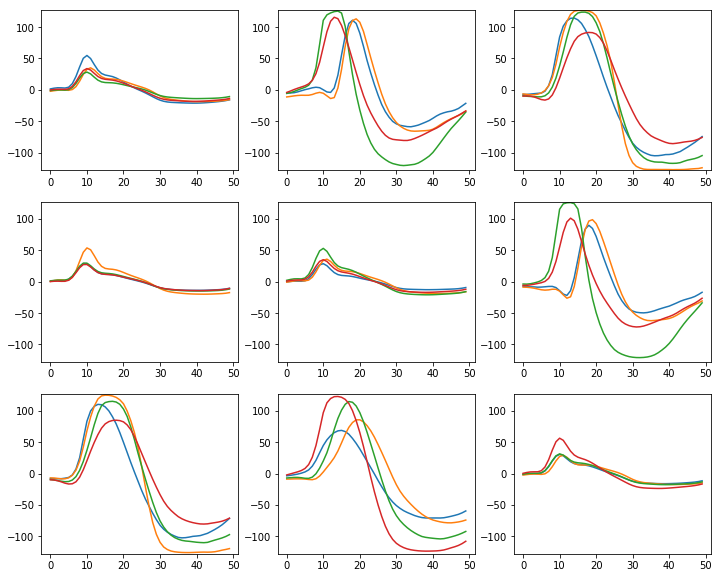

In [25]:
fig, axs = plt.subplots(rows, cols, figsize=(12, 10))

for i, ax in enumerate(axs.flatten()):
    try:
        cell = cell_ids[i]
    except IndexError:
        continue
        
    cell_ind = np.where(cell_number == cell)[0]
    
    cell_data = snippets[:,clip_inds[cell_ind],:]
    cell_data = np.mean(cell_data, axis=1)
    
    ax.plot(cell_data.T)
    # these are 8 bit values, thus we will set the limits to -128 and 127
    ax.set_ylim([-128,127])

# Visualize Output from Tint (Uses KlustaKwik)

In [26]:
def find_unit(tetrode_path, tetrode_list):
    """Inputs:
    tetrode_path: the path of the tetrode (not including the filename and extension)
    example: C:Location\of\File\filename.ext

    tetrode_list: list of tetrodes to find the units that are in the tetrode_path
    example [1,2,3], will check just the first 3 tetrodes
    -------------------------------------------------------------
    Outputs:
    cut_list: an nx1 list for n-tetrodes in the tetrode_list containing a list of unit numbers that each spike belongs to
    unique_cell_list: an nx1 list for n-tetrodes in the tetrode list containing a list of unique unit numbers"""

    cut_list = []
    unique_cell_list = []
    for tet_file in tetrode_list:
        cut_fname = os.path.join(tetrode_path, ''.join([os.path.splitext(os.path.basename(tet_file))[0],
                                                        '_', os.path.splitext(tet_file)[1][1:], '.cut']))
        extract_cut = False
        with open(cut_fname, 'r') as f:
            for line in f:
                if 'Exact_cut' in line:  # finding the beginning of the cut values
                    extract_cut = True
                if extract_cut:  # read all the cut values
                    cut_values = str(f.readlines())
                    for string_val in ['\\n', ',', "'", '[', ']']:  # removing non base10 integer values
                        cut_values = cut_values.replace(string_val, '')
                    cut_values = [int(val) for val in cut_values.split()]
                    cut_list.append(cut_values)
                    unique_cell_list.append(list(set(cut_values)))
    return np.asarray(cut_list), np.asarray(unique_cell_list)

In [27]:
tetrode_path = os.path.dirname(set_filename)
print(tetrode_path)

tetrode_list = [tetrode_filename]

cell_number_tint, cell_ids_tint = find_unit(tetrode_path, tetrode_list)
cell_number_tint = cell_number_tint.flatten()
cell_ids_tint = cell_ids_tint.flatten()

# in Tint the 0 cell is the dummy cell, so we will remove it
if 0 in cell_ids_tint:
    cell_ids_tint = cell_ids_tint[np.where(cell_ids_tint!=0)]
    
# we also skip a cell number to separate the good cells from the bad cells (so we can keep the good and bad)
# i.e. cell numbers => [1,2,3,4,6,7,8], we are missing 5, so the 1,2,3,4 are the good cells, and anything 6+ are noise
bad_cells_ind = np.where((np.diff(cell_ids_tint) == 1) == False)[0][0]

if cell_ids_tint[bad_cells_ind] != cell_ids_tint[bad_cells_ind-1]:
    # double checking that we have the correct index
    print('All Good')

cell_ids_tint = cell_ids_tint[:bad_cells_ind+1]

/mnt/e/Apollo_D_Drive/ml_ms4alg_snippets/data/MS_ANT133a-4
All Good


In [28]:
print(cell_ids_tint)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [29]:
n_cells = len(cell_ids_tint)

if np.sqrt(n_cells).is_integer():
    rows = int(np.sqrt(n_cells))
    cols = int(rows)
else:
    '''Finding geometry for the subplots'''

    value1 = int(np.ceil(np.sqrt(n_cells)))
    value2 = int(np.floor(np.sqrt(n_cells)))
    
    if value1*value2 < n_cells:
        value2 = int(np.ceil(np.sqrt(n_cells)))

    cols, rows = sorted(np.array([value1,value2]))

In [30]:
print(cols, rows)

4 5


### Initial notes, looks like our original/manual KlustaKwik method still produces more cells than the MountainSort Data, it could be because we have not whitened the data yet.

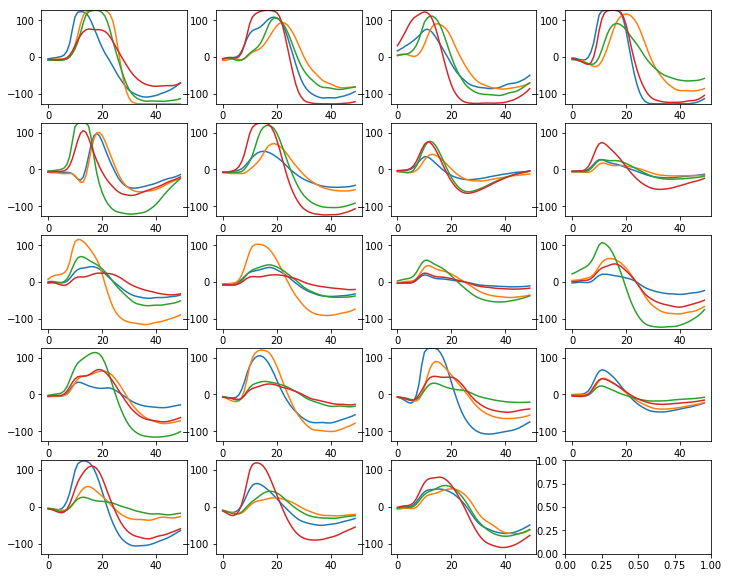

In [31]:
fig, axs = plt.subplots(rows, cols, figsize=(12, 10))

for i, ax in enumerate(axs.flatten()):
    
    try:
        cell = cell_ids_tint[i]
    except IndexError:
        continue
        
    cell_ind = np.where(cell_number_tint == cell)[0]
    
    cell_data = snippets[:,cell_ind,:]
    cell_data = np.mean(cell_data, axis=1)
    
    ax.plot(cell_data.T)
    # these are 8 bit values, thus we will set the limits to -128 and 127
    ax.set_ylim([-128,127])

# Below Here is Random Testing Code

In [32]:
temp_hdf5_path = MS._temporary_directory + '/snippets.hdf5'
X=SnippetModel_Hdf5(temp_hdf5_path)  

M=X.numChannels()-1
N=X.numTimepoints()


chunk_infos=create_chunk_infos(N=N)

In [33]:
t1 = chunk_infos[0]['t1']
t2 = chunk_infos[0]['t2']

data = X.getChunk(t1=t1,t2=t2,channels=[1,2,3,4]).astype(np.int32)

### Testing Whitening

In [34]:
output_filename = os.path.join(directory, '%s_T%d_snippets_pre.mda' % (basename, tetrode))
whiten(timeseries=mda_fname,timeseries_out=output_filename,
        clip_size=50,num_clips_per_chunk=6000,num_processes=os.cpu_count())

Chunk size: 300000, Num chunks: 25, Num processes: 12


True

In [35]:
A, code = readMDA(output_filename)

In [36]:
whitened_data = A[1:,:]
n_ch = A.shape[0]
whitened_data=whitened_data.reshape((n_channels,-1,50))
whitened_t = A[0,:].astype(np.int64)

In [37]:
whitened_t

array([      95,       96,       97, ..., 28800224, 28800224, 28800224])

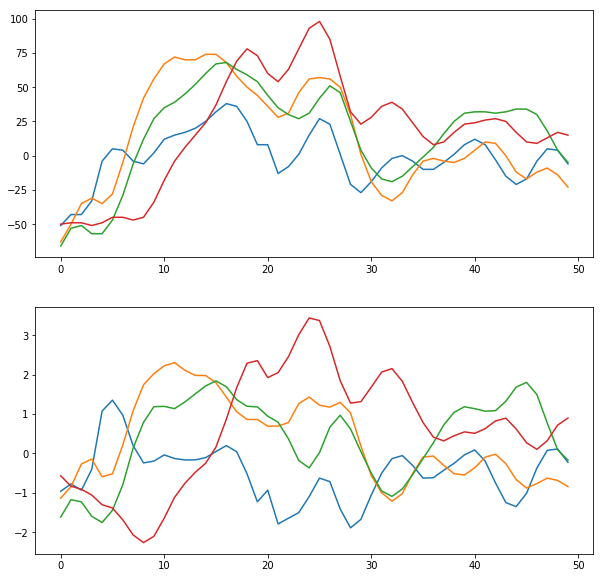

In [38]:
spike_index = 12

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(211)
ax.plot(snippets[:,spike_index,:].T)

ax = fig.add_subplot(212)
plt.plot(whitened_data[:,spike_index,:].T)

In [40]:
temp_directory = os.path.join(os.path.dirname(notebook_path), 'data', 'temp')
if not os.path.exists(temp_directory):
    os.mkdir(temp_directory)
    
firing_output = temp_directory + '/firing_whitened.mda'
print(temp_directory)

print(output_filename)

pre_snippet_path = output_filename

MS = MountainSort4_snippets()
MS.setSnippetPath(pre_snippet_path)
MS.setTemporaryDirectory(temp_directory)
MS.setFiringsOutPath(firing_output)
MS.setSortingOpts(adjacency_radius=-1,detect_sign=1,detect_interval=10,detect_threshold=3,clip_size=50,num_features=10,
                 max_num_clips_for_pca=1000)

/mnt/e/Apollo_D_Drive/ml_ms4alg_snippets/data/temp
/mnt/e/Apollo_D_Drive/ml_ms4alg_snippets/data/MS_ANT133a-4/20180530-ROUND-3300-NO-2_T1_snippets_pre.mda


In [41]:
MS.sort()

Preparing neighborhood sorters...
Detecting events on channel 2 (phase1)...
Detecting events on channel 1 (phase1)...
Detecting events on channel 3 (phase1)...
Detecting events on channel 4 (phase1)...
Computing PCA features for channel 2 (phase1)...
Computing PCA features for channel 1 (phase1)...
Computing PCA features for channel 4 (phase1)...
Computing PCA features for channel 3 (phase1)...
Clustering for channel 2 (phase1)...
Clustering for channel 1 (phase1)...
Clustering for channel 3 (phase1)...
Clustering for channel 4 (phase1)...
Found 5 clusters for channel 2 (phase1)...
Computing templates for channel 2 (phase1)...
Found 8 clusters for channel 1 (phase1)...
Computing templates for channel 1 (phase1)...
Found 8 clusters for channel 4 (phase1)...
Computing templates for channel 4 (phase1)...
Found 7 clusters for channel 3 (phase1)...
Computing templates for channel 3 (phase1)...
Re-assigning events for channel 1 (phase1)...
Re-assigning events for channel 2 (phase1)...
Re-ass

In [42]:
A, code = readMDA(firing_output)
spike_channel = A[0, :].astype(int)  # the channel which the spike belongs to
spike_times = A[1, :].astype(int)  # at this stage it is in index values (0-based)
cell_number = A[2, :].astype(int)
clip_inds = A[3, :].astype(int)

cell_ids = np.unique(cell_number)
print('%d cells found!' % len(cell_ids))

20 cells found!


In [43]:
n_cells = len(cell_ids)

if np.sqrt(n_cells).is_integer():
    rows = int(np.sqrt(n_cells))
    cols = int(rows)
else:
    '''Finding geometry for the subplots'''

    value1 = int(np.ceil(np.sqrt(n_cells)))
    value2 = int(np.floor(np.sqrt(n_cells)))
    
    if value1*value2 < n_cells:
        value2 = int(np.ceil(np.sqrt(n_cells)))

    cols, rows = sorted(np.array([value1,value2]))

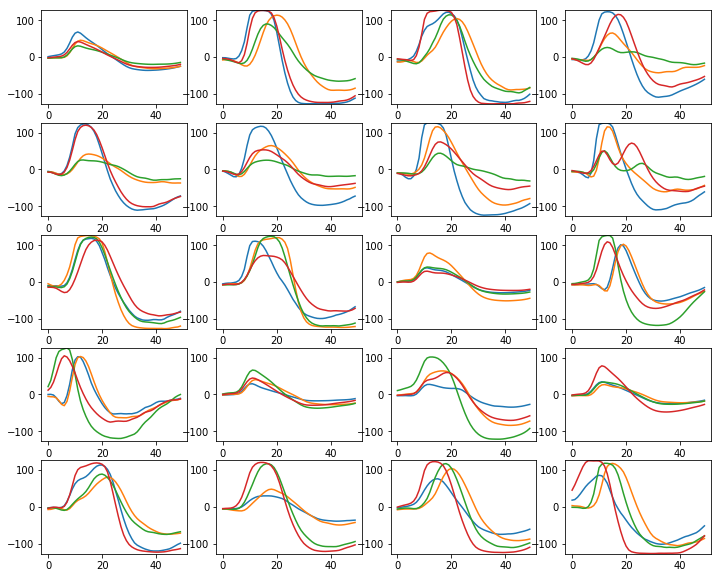

In [44]:
fig, axs = plt.subplots(rows, cols, figsize=(12, 10))

for i, ax in enumerate(axs.flatten()):
    try:
        cell = cell_ids[i]
    except IndexError:
        continue
        
    cell_ind = np.where(cell_number == cell)[0]
    
    cell_data = snippets[:,clip_inds[cell_ind],:]
    cell_data = np.mean(cell_data, axis=1)
    
    ax.plot(cell_data.T)
    # these are 8 bit values, thus we will set the limits to -128 and 127
    ax.set_ylim([-128,127])